# Two-timescale 

In [8]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import sklearn.preprocessing as skp
import torch
from tqdm import tqdm

from utils import *
from utils.modeling import init_weights, Exogenous_RkRNN, EarlyStopper

torch.set_default_dtype(torch.float32)  
results_dir = os.path.join('results', 'boundarylayer')
report_dir = os.path.join("..", "Retrain or Update Report", "figures")

logger = h5_logger(os.path.join(results_dir, "boundary_layer.h5"))

In [9]:
epsilon = 0.01 # Time-scale separation parameter
def two_time_scale(t, x):
    x_s = x[0] # Slow variable
    x_f = x[1] # Fast variable
    
    u = -0.01 * t

    # Differential equations
    dx_s = - x_s + x_f
    dx_f = (-x_f * x_s + 1 + u) / epsilon    
    return dx_s, dx_f

def layer_equation(t, x):
    x_s = x[0] # Slow variable
    x_f = x[1] # Fast variable
    
    u = -0.01 * t

    # Differential equations
    dx_s = 0
    dx_f = (-x_f * 1 + 1 + u) / epsilon
    return dx_s, dx_f

def layer_equation_corr(t, x, x_match):
    x_s = x[0] # Slow variable
    x_f = x[1] # Fast variable
    x_f_fake = x[2] # fake fast variable
    
    u = -0.01 * t

    # Differential equations
    dx_s = - x_s + x_f_fake
    dx_f = (-x_f * x_match + 1 + u) / epsilon
    dx_f_fake =  (-x_f_fake * x_s + 1 + u) / epsilon
    return dx_s, dx_f, dx_f_fake
    
def periodic_event(t, T):
    """Event function that triggers at periodic intervals"""
    value = np.mod(t, T)  # event happens when value is 0
    isterminal = 1  # stop integration at the event
    direction = 0  # detect events in any direction
    return value, isterminal, direction

In [10]:
# inputs
tf = 100
n_updates = 4

# solve ode
ts = (0, tf)
x0 = [1, 0]
t_eval = np.linspace(0, tf, 1000)
two_time_scale_solution = solve_ivp(two_time_scale, ts, x0, t_eval=t_eval, method="RK45")
layer_equation_solution = solve_ivp(layer_equation, ts, x0, t_eval=t_eval, method="RK45")

# corrected layer equation
t_ = []
x_ = []
x0 = [1, 0, 0]
x_approx = [x0[0]]  # approximation of x_slow or p
tlen = tf / n_updates
n_steps = 1000
for i in range(n_updates):
    ts = (i * tlen, (i + 1) * tlen)
    t_eval = np.linspace(ts[0], ts[1], n_steps)
    layer_equation_corr_solution = solve_ivp(layer_equation_corr, ts, x0, args=(x_approx[i],), t_eval=t_eval, method="RK45")
    t_.append(layer_equation_corr_solution.t)
    x_.append(layer_equation_corr_solution.y)
    x0 = layer_equation_corr_solution.y[:, -1]
    x_approx.append(x0[0])  # update approximation of p with actual p
layer_equation_corr_solution = {
    't': np.concatenate(t_),
    'y': np.concatenate(x_, axis=1),
    "p_approx": np.concatenate([np.ones(n_steps) * x for x in x_approx[:-1]])
}

if not logger.check_key("example/two_time_scale_solution/t"):
    logger.log_attribute("example/two_time_scale_solution/t",two_time_scale_solution.t)
    logger.log_attribute("example/two_time_scale_solution/x", two_time_scale_solution.y)
    logger.log_attribute("example/layer_equation_solution/t", layer_equation_solution.t)
    logger.log_attribute("example/layer_equation_solution/x", layer_equation_solution.y)
    logger.log_attribute("example/layer_equation_corr_solution/t", layer_equation_corr_solution['t'])
    logger.log_attribute("example/layer_equation_corr_solution/x", layer_equation_corr_solution['y'])
    logger.log_attribute("example/layer_equation_corr_solution/p_approx", layer_equation_corr_solution['p_approx'])

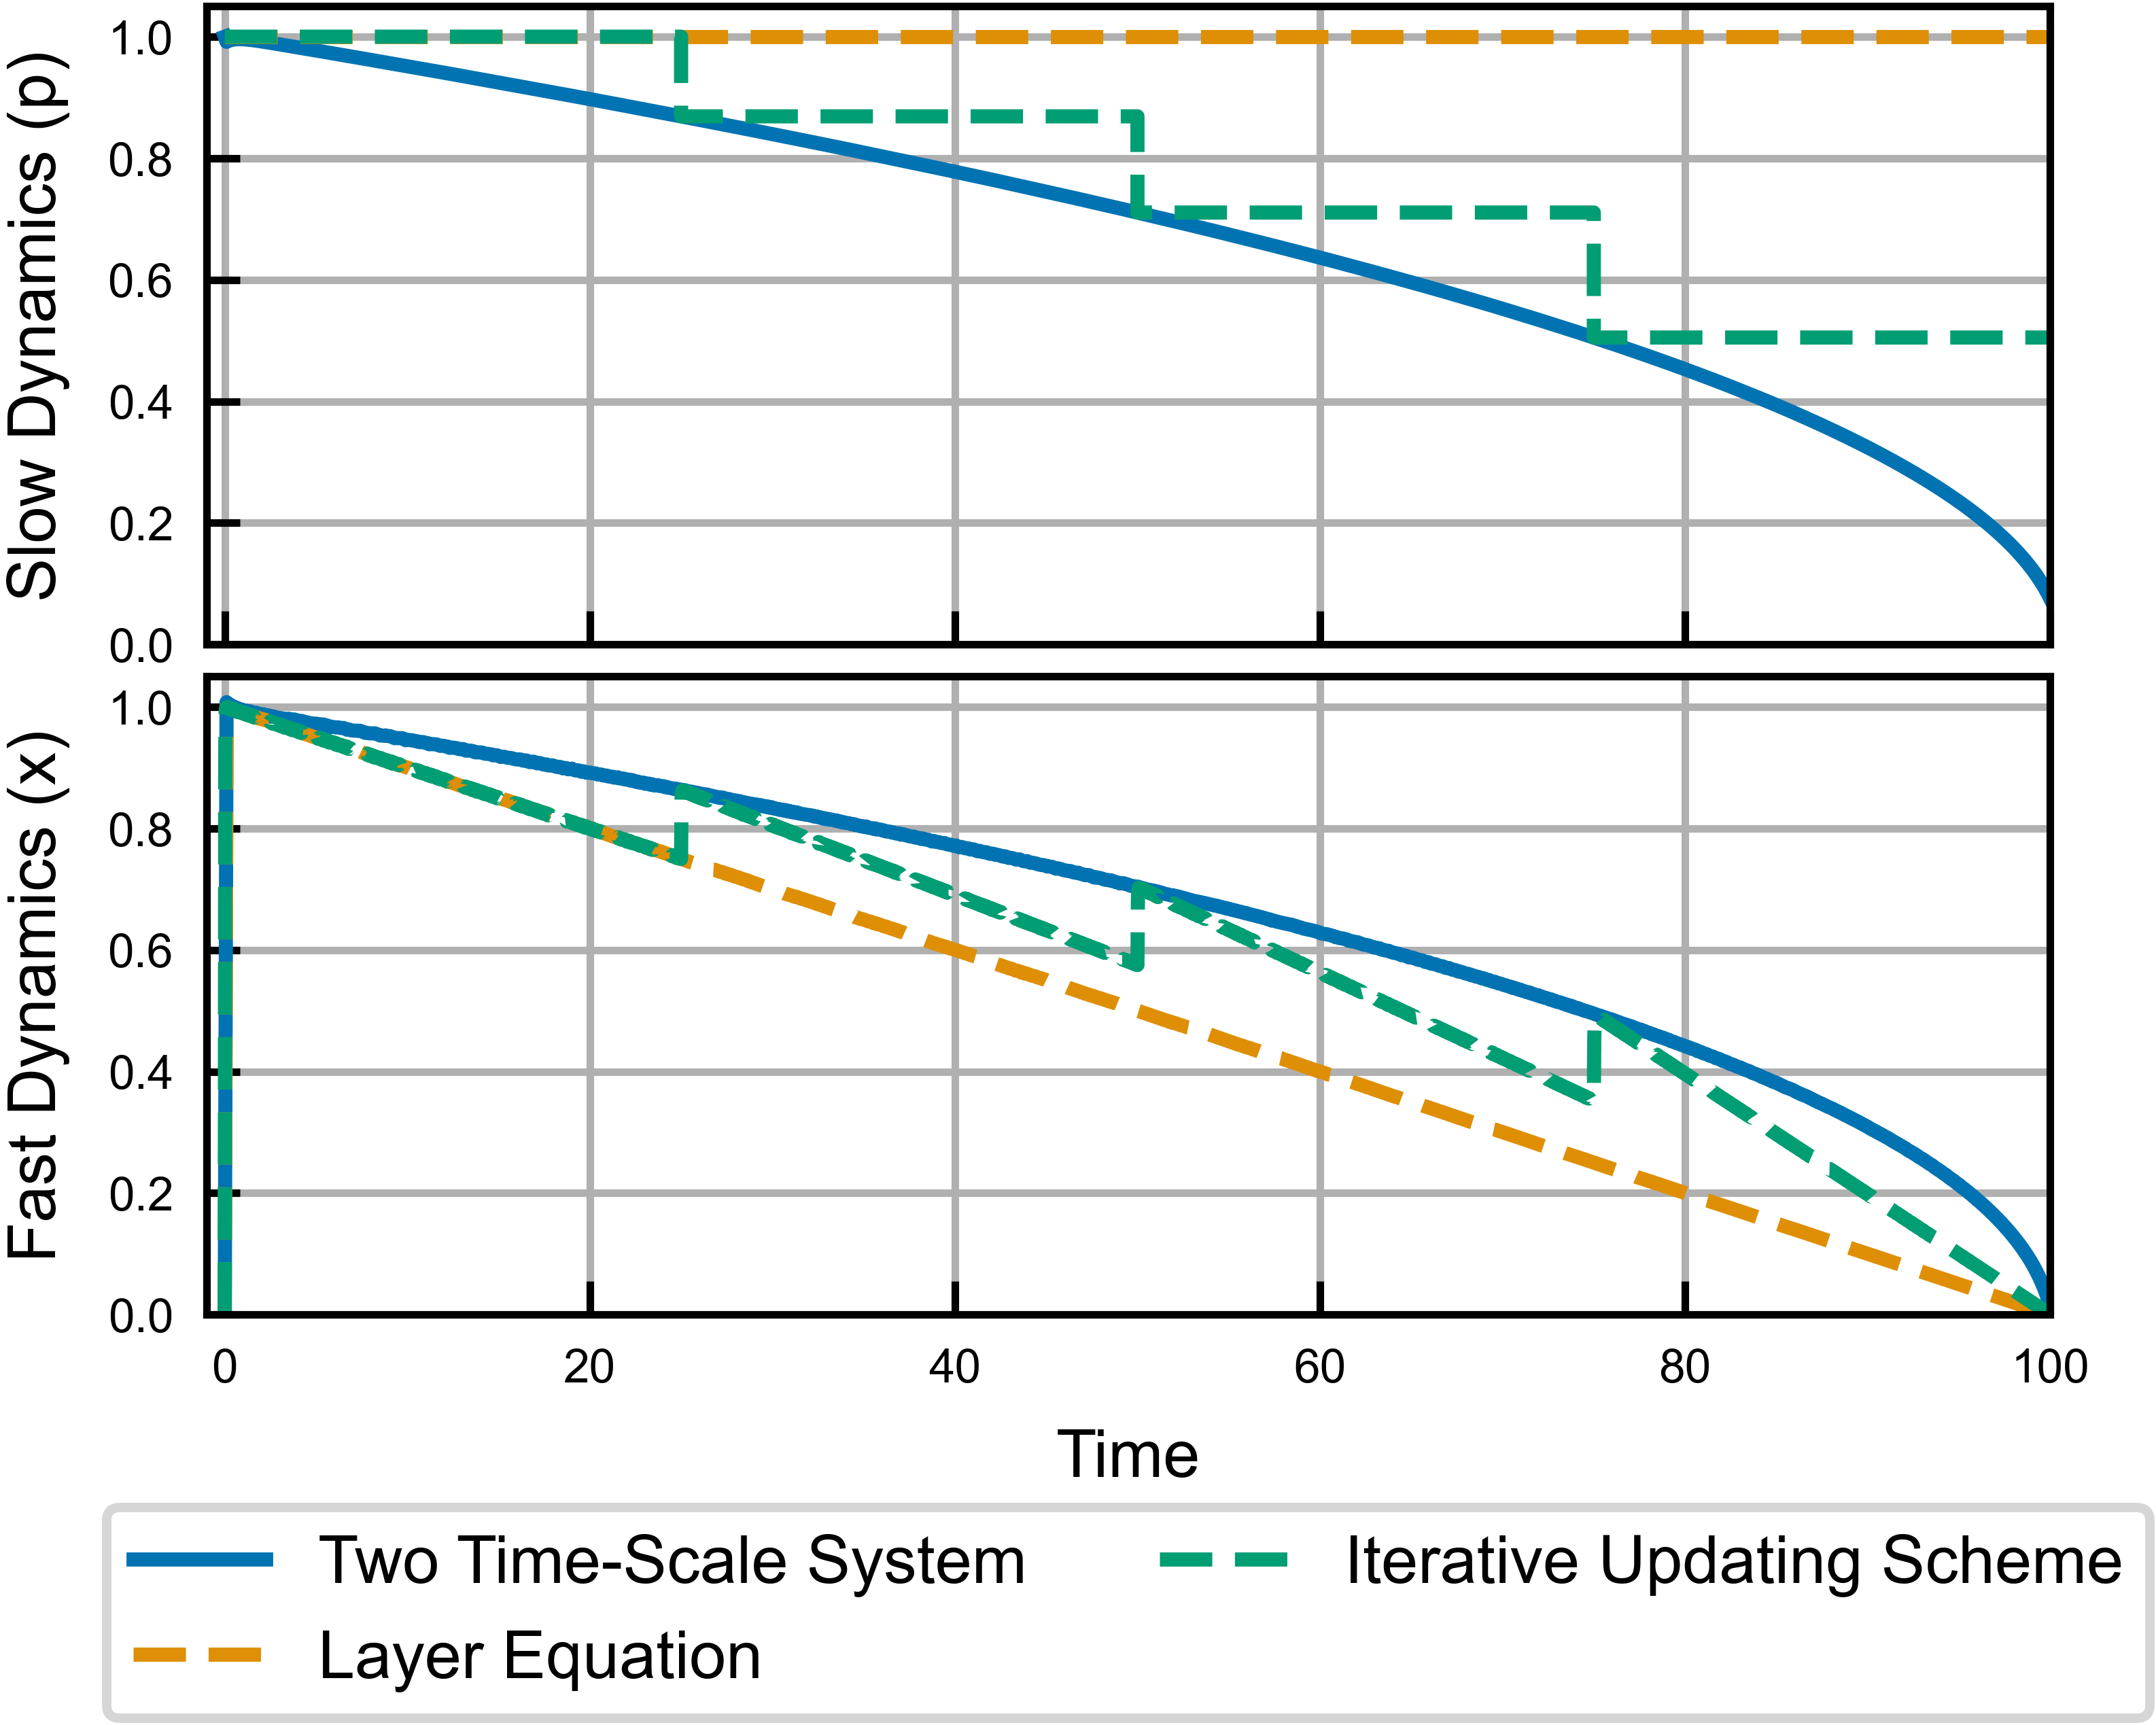

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(3.5, 2.5), sharex=True, dpi=1000)
ax[0].plot(two_time_scale_solution.t, two_time_scale_solution.y[0], label='two time scale')
ax[0].plot(layer_equation_solution.t, layer_equation_solution.y[0], linestyle="--", label='layer equation')
# ax[0].plot(layer_equation_corr_solution['t'], layer_equation_corr_solution['y'][0], linestyle="--", label='layer equation corrected')
# step_x = np.arange(0, tf+1, 25)
# step_x_indices = np.searchsorted(two_time_scale_solution.t, step_x)
# step_y = two_time_scale_solution.y[0][step_x_indices]
# ax[0].step(step_x, step_y, where='post', color='black', linestyle='-')
ax[0].plot(layer_equation_corr_solution['t'], layer_equation_corr_solution['p_approx'], linestyle="--", label='layer equation corrected')
# ax[0].set_ylabel("p")
# ax[0].set_title("Slow Dynamics")
ax[0].set_ylabel("Slow Dynamics (p)")
ax[0].set_ylim([0, 1.05])
ax[0].grid()

ax[1].plot(two_time_scale_solution.t, two_time_scale_solution.y[1], label='Two Time-Scale System')
ax[1].plot(layer_equation_solution.t, layer_equation_solution.y[1], linestyle="--", label='Layer Equation')
ax[1].plot(layer_equation_corr_solution['t'], layer_equation_corr_solution['y'][1], linestyle="--", label='Iterative Updating Scheme')
# ax[1].set_ylabel("x")
# ax[1].set_title("Fast Dynamics")
ax[1].set_ylabel("Fast Dynamics (x)")
ax[1].set_ylim([0, 1.05])
ax[1].set_xlim([-1, tf])
ax[1].set_xlabel("Time")
ax[1].grid()

ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, -0.25), ncol=2)
fig.subplots_adjust(hspace=0.05)

# fig.savefig(os.path.join(report_dir, "boundary_layer.eps"), bbox_inches="tight")

Train a neural network
$$\phi(\hat{x}_k,\hat{u}_k)\rightarrow\tilde{x}_{k+1}$$
Be sure to rank against the persistence prediction

In [12]:
# concern: approximate u as stepfunc rather than f(t)
p = 1
ts = 0.1

def generate_training_data(p=1, ts=0.25, tf=100, domain_buffer=0.1, n_samples=1_000_000, ufunc=lambda t: -0.01 * t, x0_points=None, t_points=None, verbose=True):
    """generate training data"""
    # get range of samples
    t0 = 0
    tf = 100
    trange = abs(t0 - tf)
    t_domain = [t0 - domain_buffer * trange, tf + domain_buffer * trange]
    x_domain = [-domain_buffer, 1 + domain_buffer]
    # sample
    if x0_points is not None:
        n_samples = n_samples - len(x0_points)
    if t_points is not None:
        n_samples = n_samples - len(t_points)
    x0_points = default_rng.uniform(x_domain[0], x_domain[1], n_samples)
    t_points = default_rng.uniform(t_domain[0], t_domain[1], n_samples)
    if x0_points is not None:
        x0_points = np.concatenate([x0_points, x0_points])
    if t_points is not None:
        t_points = np.concatenate([t_points, t_points])
    n_samples = len(x0_points)
    # solve ivp
    x1_points = []
    if verbose:
        print("Generating data...")
    for i in range(n_samples):
        ic = [p, x0_points[i]]
        x1_points.append(solve_ivp(two_time_scale, [t_points[i], t_points[i]+ts], ic, t_eval=[t_points[i]+ts], method="RK45").y[1][-1])
    
    return {
        'x0': x0_points,
        "t": t_points,
        'u': ufunc(t_points),
        'x1': np.array(x1_points)
    }
    
def train_test_split(data, Xscaler, Uscaler, transform_to_tensor=True, train=True, train_proportion=0.8):
    """
    ARGS
    data: dict with keys x0, u, x1
    """
    dataset_indices = np.arange(len(data["x0"]))
    default_rng.shuffle(dataset_indices)
    train_indices = dataset_indices[:int(len(data["x0"])*train_proportion)]
    test_indices = dataset_indices[int(len(data["x0"])*train_proportion):]
    new_data = {}
    
    if train:
        for k,v in data.items():
            scaler = Xscaler if k == "x0" or k == "x1" else Uscaler
            func = scaler.fit_transform if (train and (k != "x1")) else scaler.transform
            temp = func(v.reshape(-1, 1))
            new_data[k+"_train"] = temp[train_indices]
            new_data[k+"_test"] = temp[test_indices]
    
    if transform_to_tensor:
        for k,v in new_data.items():
            new_data[k] = torch.tensor(v, dtype=torch.float32, device=device)
    return new_data
    
def train_model(model, data, lr=0.01, batch_size=300, lr_patience=50, stopping_patience=100, loss_fn=torch.nn.MSELoss(), verbose=True):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.3, patience=lr_patience)
    early_stopping = EarlyStopper(patience=stopping_patience)

    # train
    epoch = 0
    train_losses = []
    test_losses = []
    persistence_loss = loss_fn(data["x1_test"], data["x0_test"])
    train_indices2 = np.arange(len(data["x0_train"]))
    while not early_stopping():
        default_rng.shuffle(train_indices2)
        x0_train = data["x0_train"][train_indices2]
        u_train = data["u_train"][train_indices2]
        x1_train = data["x1_train"][train_indices2]
        model.train()
        for i in range(0, len(x0_train), batch_size):
            opt.zero_grad()
            x0_batch = x0_train[i:i+batch_size]
            u_batch = u_train[i:i+batch_size]
            x1_batch = x1_train[i:i+batch_size]
            y_pred = model(torch.cat([x0_batch, u_batch], dim=1))
            loss = loss_fn(y_pred, x1_batch)
            loss.backward()
            opt.step()
        
        model.eval()
        with torch.no_grad():
            y_pred = model(torch.cat([x0_train, u_train], dim=1))
            loss = loss_fn(y_pred, x1_train)
            train_losses.append(loss.item())
            
            lr_scheduler.step(loss)
            y_pred = model(torch.cat([data["x0_test"], data["u_test"]], dim=1))
            test_loss = loss_fn(y_pred, data["x1_test"])
            test_losses.append(test_loss.item())
        
        epoch += 1
        early_stopping.step(train_losses[-1])
        if verbose:
            print(f"Epoch {int(epoch):6,d} Train Loss: {train_losses[-1]:.4e}, Test Loss: {test_losses[-1]:.4e}, Persistence Loss: {persistence_loss:.4e}, lr: {opt.param_groups[0]['lr']:.4e}, patience: {early_stopping.counter:3,d}/{early_stopping.patience:3,d}", end="\r")
    return model, {"train_losses": train_losses, "test_losses": test_losses, "persistence_loss": persistence_loss}

def sim_model(model, x0, trange, Xscaler, Uscaler, ts=ts):
    tspan = np.arange(trange[0], trange[1]+ts, ts)
    uspan = -0.01 * tspan
    uspan_scaled = torch.tensor(Uscaler.transform(uspan.reshape(-1, 1)), dtype=torch.float32, device=device)
    x_predictions = [torch.tensor(Xscaler.transform(np.array([x0]).reshape(-1, 1)).reshape(1), dtype=torch.float32, device=device)]
    for i in range(len(tspan) - 1):
        x_predictions.append(model(torch.cat([x_predictions[-1], uspan_scaled[i]])))
    x_predictions_rescaled = Xscaler.inverse_transform(torch.tensor(x_predictions).cpu().detach().numpy().reshape(-1, 1)).flatten()
    return tspan, x_predictions_rescaled

def model_and_sim(p, t0, tf, x0):
    # data
    data = generate_training_data(p=p, ts=ts, tf=tf, n_samples=10_000, x0_points=two_time_scale_solution.y[1], t_points=two_time_scale_solution.t)
    data = train_test_split(data, Xscaler, Uscaler, transform_to_tensor=True, train=True)
    # model init
    model = torch.nn.Sequential(
        torch.nn.Linear(2, 10),
        torch.nn.Sigmoid(),
        torch.nn.Linear(10, 1),
    )
    model.to(device)
    model.apply(init_weights)
    # train
    model, training_data = train_model(model, data)
    # sim
    tspan, xpred = sim_model(model, x0=np.array([x0]), trange=[t0, tf], Xscaler=Xscaler, Uscaler=Uscaler, ts=ts)
    return tspan, xpred, model

# train model with two time scale solution and constant p for values of p at 0, 25, 50, 75
Xscaler = skp.MinMaxScaler()
Uscaler = skp.MinMaxScaler()
data = generate_training_data(p=1, ts=ts, tf=100, n_samples=10_000, x0_points=two_time_scale_solution.y[1], t_points=two_time_scale_solution.t, verbose=False)
Xscaler.fit(data["x0"].reshape(-1, 1))
Uscaler.fit(data["u"].reshape(-1, 1))

# train model, simulate, or load model and simulate
if os.path.exists(os.path.join("results", "boundarylayer", "model_t0.pt")):
    model_t0 = torch.load(os.path.join("results", "boundarylayer", "model_t0.pt"))
    tspan_t0, xpred_t0 = sim_model(model_t0, x0=0, trange=[0, 100], Xscaler=Xscaler, Uscaler=Uscaler, ts=ts)
else:
    tspan_t0, xpred_t0, model_t0 = model_and_sim(p=1, t0=0, tf=100, x0=0)  
    torch.save(model_t0, os.path.join("results", "boundarylayer", "model_t0.pt")) 

p_t25, x_t25  = two_time_scale_solution.y[0][np.searchsorted(two_time_scale_solution.t, 25)], two_time_scale_solution.y[1][np.searchsorted(two_time_scale_solution.t, 25)]
if os.path.exists(os.path.join("results", "boundarylayer", "model_t25.pt")):
    model_t25 = torch.load(os.path.join("results", "boundarylayer", "model_t25.pt"))
    tspan_t25, xpred_t25 = sim_model(model_t25, x0=x_t25, trange=[25, 100], Xscaler=Xscaler, Uscaler=Uscaler, ts=ts)
else:
    tspan_t25, xpred_t25, model_t25 = model_and_sim(p=p_t25, t0=25, tf=100, x0=x_t25)  
    torch.save(model_t25, os.path.join("results", "boundarylayer", "model_t25.pt")) 
    
p_t50, x_t50  = two_time_scale_solution.y[0][np.searchsorted(two_time_scale_solution.t, 50)], two_time_scale_solution.y[1][np.searchsorted(two_time_scale_solution.t, 50)]
if os.path.exists(os.path.join("results", "boundarylayer", "model_t50.pt")):
    model_t50 = torch.load(os.path.join("results", "boundarylayer", "model_t50.pt"))
    tspan_t50, xpred_t50 = sim_model(model_t50, x0=x_t50, trange=[50, 100], Xscaler=Xscaler, Uscaler=Uscaler, ts=ts)
else:
    tspan_t50, xpred_t50, model_t50 = model_and_sim(p=p_t50, t0=50, tf=100, x0=x_t50)  
    torch.save(model_t50, os.path.join("results", "boundarylayer", "model_t50.pt")) 
    
p_t75, x_t75  = two_time_scale_solution.y[0][np.searchsorted(two_time_scale_solution.t, 75)], two_time_scale_solution.y[1][np.searchsorted(two_time_scale_solution.t, 75)]
if os.path.exists(os.path.join("results", "boundarylayer", "model_t75.pt")):
    model_t75 = torch.load(os.path.join("results", "boundarylayer", "model_t75.pt"))
    tspan_t75, xpred_t75 = sim_model(model_t75, x0=x_t75, trange=[75, 100], Xscaler=Xscaler, Uscaler=Uscaler, ts=ts)
else:
    tspan_t75, xpred_t75, model_t75 = model_and_sim(p=p_t75, t0=75, tf=100, x0=x_t75)  
    torch.save(model_t75, os.path.join("results", "boundarylayer", "model_t75.pt")) 

logger.log_attribute("example/model_t0/t", tspan_t0)
logger.log_attribute("example/model_t0/x", xpred_t0)
logger.log_attribute("example/model_t0/p_approx", np.array([1]), replace=True)
logger.log_attribute("example/model_t25/t", tspan_t25)
logger.log_attribute("example/model_t25/x", xpred_t25)
logger.log_attribute("example/model_t25/p_approx", np.array([p_t25]), replace=True)
logger.log_attribute("example/model_t50/t", tspan_t50)
logger.log_attribute("example/model_t50/x", xpred_t50)
logger.log_attribute("example/model_t50/p_approx", np.array([p_t50]), replace=True)
logger.log_attribute("example/model_t75/t", tspan_t75)
logger.log_attribute("example/model_t75/x", xpred_t75)
logger.log_attribute("example/model_t75/p_approx", np.array([p_t75]), replace=True)


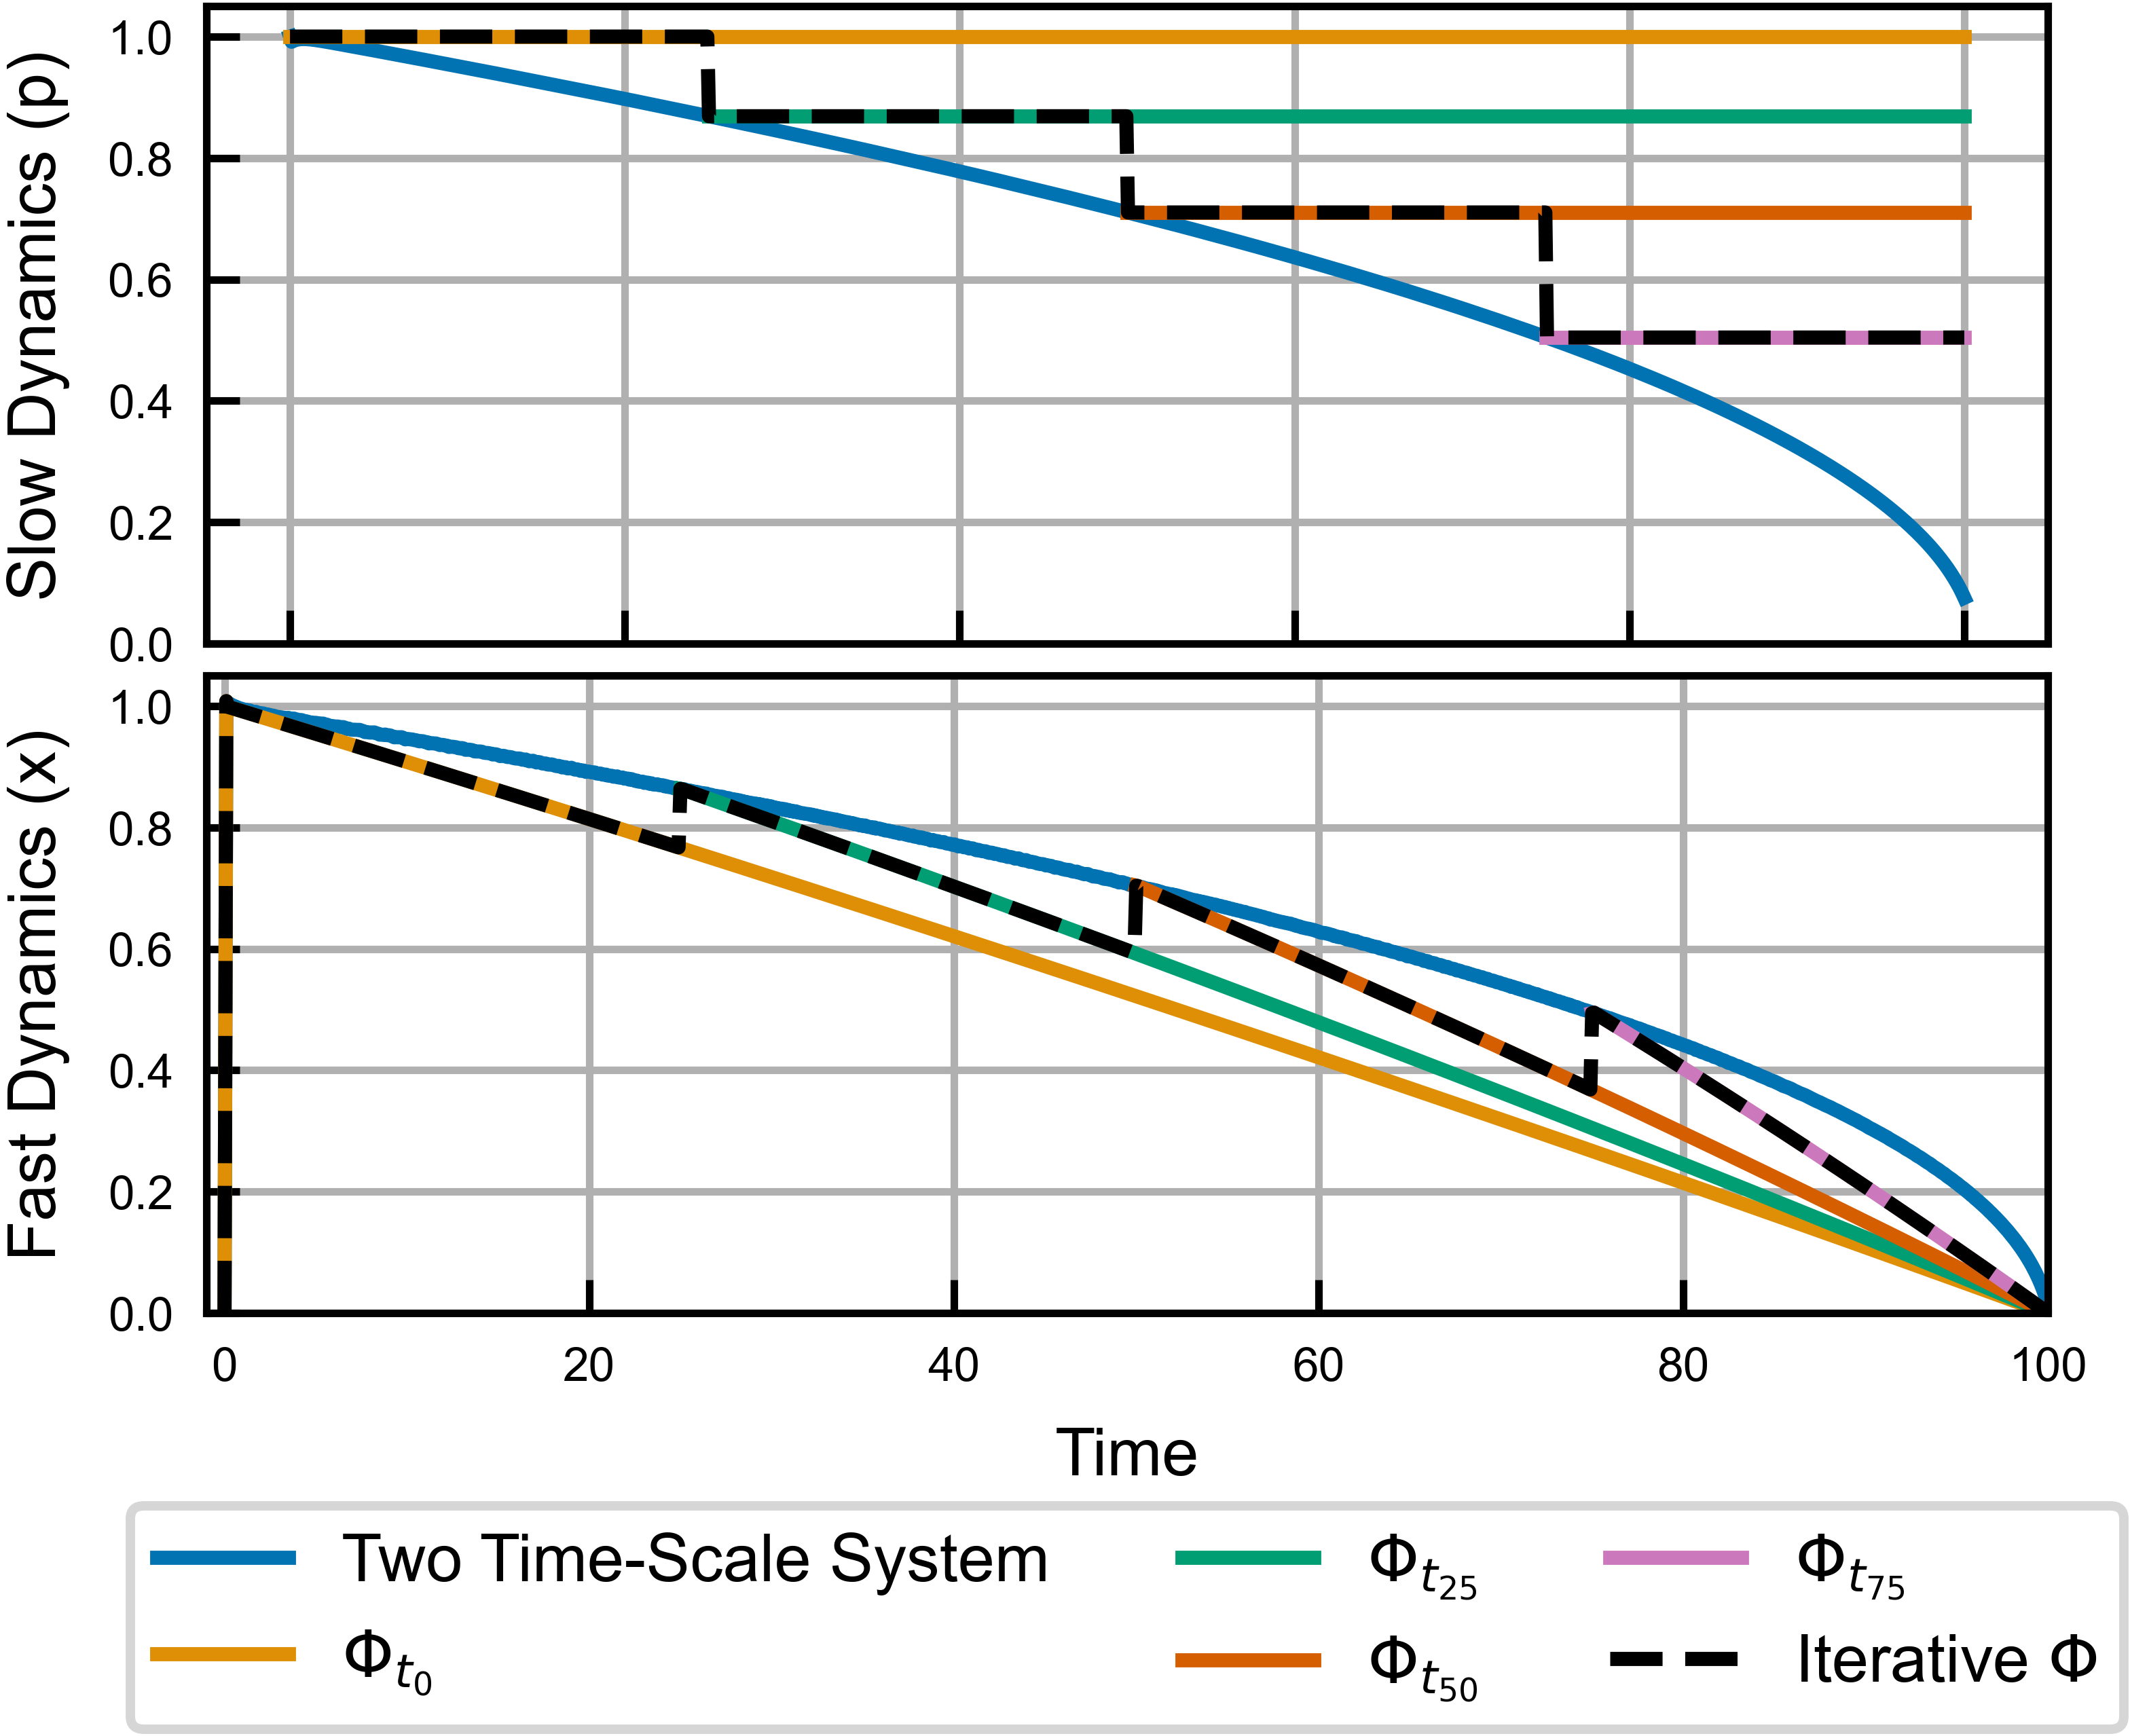

In [13]:
# create stepwise array of p
p_approx = np.ones_like(two_time_scale_solution.t)
p_approx[np.searchsorted(two_time_scale_solution.t, 25):] = p_t25
p_approx[np.searchsorted(two_time_scale_solution.t, 50):] = p_t50
p_approx[np.searchsorted(two_time_scale_solution.t, 75):] = p_t75
x_approx = xpred_t0.copy()
x_approx[-len(tspan_t25):] = xpred_t25
x_approx[-len(tspan_t50):] = xpred_t50
x_approx[-len(tspan_t75):] = xpred_t75

# plot
fig, ax = plt.subplots(2, 1, figsize=(3.5, 2.5), dpi=1000)
ax[0].plot(two_time_scale_solution.t, two_time_scale_solution.y[0], label='two time scale')
ax[0].plot(tspan_t0, np.ones_like(tspan_t0), label=r'$\Phi_{t_0}$')
ax[0].plot(tspan_t25, np.ones_like(tspan_t25) * p_t25, label=r'$\Phi_{t_{25}}$')
ax[0].plot(tspan_t50, np.ones_like(tspan_t50) * p_t50, label=r'$\Phi_{t_{50}}$')
ax[0].plot(tspan_t75, np.ones_like(tspan_t75) * p_t75, label=r'$\Phi_{t_{75}}$')
ax[0].plot(two_time_scale_solution.t, p_approx, "k--",label=r'Iterative $p_\Phi$')
ax[0].set_ylabel("Slow Dynamics (p)")
ax[0].set_ylim([0, 1.05])
ax[0].grid()

ax[1].plot(two_time_scale_solution.t, two_time_scale_solution.y[1], label='Two Time-Scale System')
ax[1].plot(tspan_t0, xpred_t0, label=r'$\Phi_{t_0}$')
ax[1].plot(tspan_t25, xpred_t25, label=r'$\Phi_{t_{25}}$')
ax[1].plot(tspan_t50, xpred_t50, label=r'$\Phi_{t_{50}}$')
ax[1].plot(tspan_t75, xpred_t75, label=r'$\Phi_{t_{75}}$')
ax[1].plot(tspan_t0, x_approx, "k--",label=r'Iterative $\Phi$')
ax[1].set_ylabel("Fast Dynamics (x)")
ax[1].set_ylim([0, 1.05])
ax[1].set_xlim([-1, tf])
ax[1].set_xlabel("Time")
ax[1].grid()
ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, -0.25), ncol=3)
fig.subplots_adjust(hspace=0.05)
# fig.savefig(os.path.join(report_dir, "boundary_layer_nn.eps"), bbox_inches="tight")

# fig, ax = plt.subplots(2, 1, figsize=(3.5, 2.5), sharex=True, dpi=1000)
# ax[0].plot(two_time_scale_solution.t, two_time_scale_solution.y[0], label='two time scale')
# ax[0].plot(two_time_scale_solution.t, p_approx, label=r'$p_\Phi$')
# # ax[0].plot(tspan_t0, np.ones_like(tspan_t0), label=r'$\Phi_{t_0}$')
# # ax[0].plot(tspan_t25, np.ones_like(tspan_t25) * p_t25, label=r'$\Phi_{t_{25}}$')
# # ax[0].plot(tspan_t50, np.ones_like(tspan_t50) * p_t50, label=r'$\Phi_{t_{50}}$')
# # ax[0].plot(tspan_t75, np.ones_like(tspan_t75) * p_t75, label=r'$\Phi_{t_{75}}$')
# ax[0].set_ylabel("Slow Dynamics (p)")
# ax[0].set_ylim([0, 1.05])
# ax[0].grid()

# ax[1].plot(two_time_scale_solution.t, two_time_scale_solution.y[1], label='two time scale')
# ax[1].plot(tspan_t0, x_approx, label=r'$\Phi$')
# # ax[1].plot(tspan_t0, xpred_t0, label=r'$\Phi_{t_0}$')
# # ax[1].plot(tspan_t25, xpred_t25, label=r'$\Phi_{t_{25}}$')
# # ax[1].plot(tspan_t50, xpred_t50, label=r'$\Phi_{t_{50}}$')
# # ax[1].plot(tspan_t75, xpred_t75, label=r'$\Phi_{t_{75}}$')
# ax[1].set_ylabel("Fast Dynamics (x)")
# ax[1].set_ylim([0, 1.05])
# ax[1].set_xlim([-1, tf])
# ax[1].set_xlabel("Time")
# ax[1].grid()

# ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, -0.25), ncol=2)
# fig.subplots_adjust(hspace=0.05)

logger.log_attribute("example/model_approx/p_approx", p_approx)
logger.log_attribute("example/model_approx/x_approx", x_approx)

## update nn as time progresses

In [14]:
x0 = [1,0]

sol = solve_ivp(two_time_scale, (0, 100), x0, t_eval=np.linspace(0, 100, 1001), method="RK45")

### Inputs ###
train_boundary = 15
validation_boundary = 20
minibatch_size = 5
###
uvals = sol.t[:-1] * -0.01
x0vals = sol.y[1,:-1]
x1vals = sol.y[1,1:]

total_indices = np.arange(len(x0vals))
train_indices = total_indices[sol.t[:-1] < train_boundary]
val_indices = total_indices[(sol.t[:-1] >= train_boundary) & (sol.t[:-1] < validation_boundary)]

# Xscaler = skp.MinMaxScaler()
# Uscaler = skp.MinMaxScaler()

# Xscaler.fit(x0vals[train_indices].reshape(-1, 1))
# Uscaler.fit(uvals[train_indices].reshape(-1, 1))

# x0_tensor = torch.tensor(Xscaler.transform(x0vals.reshape(-1, 1)), dtype=torch.float32, device=device)
# u_tensor = torch.tensor(Uscaler.transform(u.reshape(-1, 1)), dtype=torch.float32, device=device)
# x1_tensor = torch.tensor(Xscaler.transform(x1vals.reshape(-1, 1)), dtype=torch.float32, device=device)
x0_tensor = torch.tensor(x0vals, dtype=torch.float32, device=device).reshape(-1, 1)
u_tensor = torch.tensor(uvals, dtype=torch.float32, device=device).reshape(-1, 1)
x1_tensor = torch.tensor(x1vals, dtype=torch.float32, device=device).reshape(-1, 1)

if not os.path.exists(os.path.join(results_dir, "initial_nn.pt")):

    nn = torch.nn.Sequential(
        torch.nn.Linear(2, 10),
        torch.nn.Sigmoid(),
        torch.nn.Linear(10, 1),
    )
    nn.apply(init_weights)
    nn.to(device)

    opt = torch.optim.Adam(nn.parameters(), lr=0.01)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.3, patience=50)
    loss_fn = torch.nn.MSELoss()

    train_losses = []
    val_losses = []

    shuffled_train_indices = train_indices.copy()

    # initial training
    for epoch in range(1000):
        np.random.shuffle(shuffled_train_indices)
        for i in range(0, len(train_indices), minibatch_size):
            opt.zero_grad()
            x0_batch = x0_tensor[shuffled_train_indices[i:i+minibatch_size]]
            u_batch = u_tensor[shuffled_train_indices[i:i+minibatch_size]]
            x1_batch = x1_tensor[shuffled_train_indices[i:i+minibatch_size]]
            y_pred = nn(torch.cat([x0_batch, u_batch], dim=1))
            loss = torch.nn.L1Loss()(y_pred, x1_batch)
            loss.backward()
            opt.step()
        with torch.no_grad():
            train_pred = nn(torch.cat([x0_tensor[train_indices], u_tensor[train_indices]], dim=1))
            train_loss = loss_fn(train_pred, x1_tensor[train_indices])
            val_pred = nn(torch.cat([x0_tensor[val_indices], u_tensor[val_indices]], dim=1))
            val_loss = loss_fn(val_pred, x1_tensor[val_indices])
            train_losses.append(train_loss.item())
            val_losses.append(val_loss.item())
        lr_scheduler.step(train_loss)
        print(f"Epoch {epoch:4,d} Train Loss: {train_losses[-1]:.4e}, Val Loss: {val_losses[-1]:.4e}", end="\r")

    torch.save(nn, os.path.join(results_dir, "initial_nn.pt"))

    fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.5), dpi=1000)
    ax.plot(train_losses, label="Train Loss")
    ax.plot(val_losses, label="Validation Loss")
    ax.set_yscale("log")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()
    plt.show()
else:
    nn = torch.load(os.path.join(results_dir, "initial_nn.pt"), map_location=device)

In [17]:
from utils.optimizers import GEKF, maskedAdam
from utils.modeling import get_jacobian, get_parameter_gradient_vector, mask_fn

def kf_iteration(model, nn_input, pred_true, loss_fn, opt, mask_fn=mask_fn):
    opt.zero_grad()
    xp = model(nn_input)
    innovation = pred_true - xp
    loss = loss_fn(pred_true, xp)
    with torch.no_grad():
        j = get_jacobian(model, nn_input)
    loss.backward()
    grads = get_parameter_gradient_vector(model)
    mask = mask_fn(grads)
    opt.step(innovation, j, mask)
    return xp

def kf_trial(opt_lr, mask_fn=mask_fn):
    nn = torch.load(os.path.join(results_dir, "initial_nn.pt"), map_location=device)
    opt = GEKF(nn.parameters(), lr=opt_lr)
    loss_fn = torch.nn.L1Loss()
    
    e = []
    xpred = []
    t = [time.time()]
    for i in total_indices:
        x0 = x0_tensor[i]
        u = u_tensor[i]
        x1 = x1_tensor[i]
        nn_input = torch.cat([x0, u])
        
        xp = kf_iteration(nn, nn_input, x1, loss_fn, opt, mask_fn)
        
        e.append((x1 - xp))
        xpred.append(xp)
        t.append(time.time())
        
    e = torch.tensor(e).detach().cpu().numpy()
    xpred = torch.tensor(xpred).detach().cpu().numpy()
    t = np.diff(t)
    return {"e": e, "xpred": xpred, "t": t}

def online_adam_trial(opt_lr, mask_fn=mask_fn):
    nn = torch.load(os.path.join(results_dir, "initial_nn.pt"), map_location=device)
    opt = maskedAdam(nn.parameters(), lr=opt_lr)
    loss_fn = torch.nn.L1Loss()
    
    e = []
    xpred = []
    t = [time.time()]
    for i in total_indices:
        x0 = x0_tensor[i]
        u = u_tensor[i]
        x1 = x1_tensor[i]
        nn_input = torch.cat([x0, u])
        
        opt.zero_grad()
        xp = nn(nn_input)
        loss = loss_fn(x1, xp)
        loss.backward()
        grads = get_parameter_gradient_vector(nn)
        opt.masked_step(mask=mask_fn(grads))
        
        e.append((x1 - xp))
        xpred.append(xp)
        t.append(time.time())
        
    e = torch.tensor(e).detach().cpu().numpy()
    xpred = torch.tensor(xpred).detach().cpu().numpy()
    t = np.diff(t)
    return {"e": e, "xpred": xpred, "t": t}
        
def retraining_iteration(opt_lr, 
        mask_fn=mask_fn, data_horizon_len=100, loss_threshold=0.05, 
        retrain_epochs=50, retrain_minibatch_size=5, 
        retrain_early_stopping_threshold=None, finetune=True):
    nn = torch.load(os.path.join(results_dir, "initial_nn.pt"), map_location=device)
    opt = maskedAdam(nn.parameters(), lr=opt_lr)
    loss_fn = torch.nn.L1Loss()
    
    e = []
    xpred = []
    t = [time.time()]
    for i in total_indices:
        x0 = x0_tensor[i]
        u = u_tensor[i]
        x1 = x1_tensor[i]
        nn_input = torch.cat([x0, u])
        
        xp =nn(nn_input)
        
        e.append((x1 - xp))
        xpred.append(xp)
        
        loss = loss_fn(x1, xp)
        if loss > loss_threshold:
            if not finetune:
                # re-initialize model parameters
                nn.apply(init_weights)
            min_i = max(0, i - data_horizon_len)
            n_minibatches = (i-min_i) // retrain_minibatch_size
            shuffled_indices = np.arange(min_i, i)
            for retrain_epoch in range(retrain_epochs):
                np.random.shuffle(shuffled_indices)
                for retrain_minibatch_i in range(n_minibatches):
                    minibatch_indices = shuffled_indices[retrain_minibatch_i*retrain_minibatch_size:(retrain_minibatch_i+1)*retrain_minibatch_size]
                    x0_minibatch = x0_tensor[minibatch_indices]
                    u_minibatch = u_tensor[minibatch_indices]
                    x1_minibatch = x1_tensor[minibatch_indices]
                    
                    opt.zero_grad()
                    xp_minibatch = nn(torch.cat([x0_minibatch, u_minibatch], dim=1))
                    minibatch_loss = loss_fn(x1_minibatch, xp_minibatch)
                    minibatch_loss.backward()
                    grads = get_parameter_gradient_vector(nn)
                    opt.masked_step(mask=mask_fn(grads))
                    
                xp = nn(torch.cat([x0_tensor[min_i:i], u_tensor[min_i:i]], dim=1))
                loss = loss_fn(x1_tensor[min_i:i], xp)
                if retrain_early_stopping_threshold is not None:
                    if loss < retrain_early_stopping_threshold:
                        break
        t.append(time.time())
    e = torch.tensor(e).detach().cpu().numpy()
    xpred = torch.tensor(xpred).detach().cpu().numpy()
    t = np.diff(t)
    return {"e": e, "xpred": xpred, "t": t}

def try_all_maintenance_methods(opt_lr, mask_fn, retraining_args={}):
    return {"SEKF" : kf_trial(opt_lr, mask_fn),
    "Online Adam" : online_adam_trial(opt_lr, mask_fn),
    "Retraining" : retraining_iteration(opt_lr, mask_fn, finetune=False, **retraining_args),
    "Finetuning" : retraining_iteration(opt_lr, mask_fn, finetune=True, **retraining_args)}
    
nn = torch.load(os.path.join(results_dir, "initial_nn.pt"), map_location=device)
opt = GEKF(nn.parameters(), lr=0.01)
loss_fn = torch.nn.L1Loss()

opt.zero_grad()
training_pred = nn(torch.cat([x0_tensor[train_indices], u_tensor[train_indices]], dim=1))
training_loss = loss_fn(training_pred, x1_tensor[train_indices])
training_jac = get_jacobian(nn, torch.cat([x0_tensor[train_indices], u_tensor[train_indices]], dim=1))
training_loss.backward()
training_grads = get_parameter_gradient_vector(nn)
opt.zero_grad()
validation_pred = nn(torch.cat([x0_tensor[val_indices], u_tensor[val_indices]], dim=1))
validation_loss = loss_fn(validation_pred, x1_tensor[val_indices])
validation_jac = get_jacobian(nn, torch.cat([x0_tensor[val_indices], u_tensor[val_indices]], dim=1))
validation_loss.backward()
validation_grads = get_parameter_gradient_vector(nn)
abs_validation_grads = torch.abs(validation_grads).detach().cpu().numpy()
    
# mask_functions
mask_functions = {
    "All Parameters": mask_fn,
    # "No Parameters": lambda x: torch.zeros_like(x, dtype=torch.bool),
    "Prop.99": lambda x: mask_fn(x, quantile_thresh=0.99),
    "Prop.95": lambda x: mask_fn(x, quantile_thresh=0.95),
    "Prop.90": lambda x: mask_fn(x, quantile_thresh=0.90),
    "Prop.75": lambda x: mask_fn(x, quantile_thresh=0.75),
    "Prop.50": lambda x: mask_fn(x, quantile_thresh=0.50),
    "Mag.99": lambda x: mask_fn(x, thresh=np.quantile(abs_validation_grads, 0.99)),
    "Mag.95": lambda x: mask_fn(x, thresh=np.quantile(abs_validation_grads, 0.95)),
    "Mag.90": lambda x: mask_fn(x, thresh=np.quantile(abs_validation_grads, 0.90)),
    "Mag.75": lambda x: mask_fn(x, thresh=np.quantile(abs_validation_grads, 0.75)),
    "Mag.50": lambda x: mask_fn(x, thresh=np.quantile(abs_validation_grads, 0.50))
}

retraining_args = {
    "data_horizon_len": 100,
    "loss_threshold": 0.005,
    "retrain_epochs": 50,
    "retrain_minibatch_size": 5,
    "retrain_early_stopping_threshold": None
}

learning_rates = [0.1, 0.01, 0.001, 0.0001]

# total_len = len(learning_rates) * len(list(mask_functions.keys()))
# trial_no = 0
# for lr in learning_rates:
#     for k, v in mask_functions.items():
#         print(f"{trial_no}/{total_len} lr: {lr}, mask: {k}", end="\r")
#         results = try_all_maintenance_methods(lr, v, retraining_args=retraining_args)
#         for k2, v2 in results.items():
#             logger.log_attribute(f"{k2}/{k}/{lr}/e", v2["e"])
#             logger.log_attribute(f"{k2}/{k}/{lr}/xpred", v2["xpred"])
#             logger.log_attribute(f"{k2}/{k}/{lr}/t", v2["t"])
#             if k2 in ["Retraining", "Finetuning"]:
#                 for k3, v3 in retraining_args.items():
#                     if v3 is not None:
#                         logger.log_attribute(f"{k2}/{k}/{lr}/{k3}", np.array(v3))
                        
#         trial_no += 1    

In [18]:
control_predictions = nn(torch.cat([x0_tensor, u_tensor], dim=1))
control_error = x1_tensor - control_predictions
control_error = control_error.detach().cpu().numpy()
control_predictions = control_predictions.detach().cpu().numpy()
logger.log_attribute("control/error", control_error)
logger.log_attribute("control/predictions", control_predictions)
control_gradients = []
for i in range(x0_tensor.shape[0]):
    opt.zero_grad()
    xp = nn(torch.cat([x0_tensor[i], u_tensor[i]]))
    loss = loss_fn(x1_tensor[i], xp)
    loss.backward()
    control_gradients.append(get_parameter_gradient_vector(nn).detach().cpu().numpy())
control_gradients = np.array(control_gradients)
logger.log_attribute("control/gradients", control_gradients)